In [1]:
# !pip install catboost
# !pip install transformers
# !pip install nltk
# !pip install nlpaug
# !pip install evaluate

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.4 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r requirements.txt (line 143))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [3]:
import json
import gc
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from copy import deepcopy
from IPython.display import clear_output
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from scipy.sparse import coo_matrix, hstack
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    multilabel_confusion_matrix,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import catboost
from catboost import CatBoostClassifier, Pool
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    AdamW,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup,
)
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.augmenter.word as naw
import nlpaug.flow as nafc
from nlpaug.util import Action

In [4]:
from src.functions_bert import dataset, inference, f1_score_func_m, trainer, evaluate, trainer_pipeline
from src.functions_LR import count_words, text2emb_bert, dataset_pipeline

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Загрузим данные

In [6]:
PATH = './data/GBC_NLP_test_news_sample.json'
texts = []
labels = []

with open(PATH) as f:
    data = json.load(f)

for row in data:
    texts.append(row['content'])
    labels.append(row['classification'])

f.close()

In [7]:
df = pd.DataFrame({'text' : texts, 'label' : labels})
df.head()

,text,label
0,The Mines of Dalarnia Update 1.4: Rechained is...,"development, specified"
1,Mines of Dalarnia Mainnet—Update 1.4: Rechained,"development, specified"
2,Kava in the news [kava 14 accelerates cosmos e...,"development, specified"
3,SEC responsed: We are pleased that the court f...,sec
4,Build on Base Mainnet with 1RPC,"development, specified"


### EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    835 non-null    object
 1   label   835 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


У нас 835 объектов без пропусков

In [9]:

df['label'].value_counts()

development, specified     280
partnership, non-crypto    264
development                 66
announcement promise        59
legal, negative             39
start of burn/buyback       32
legal, positive             21
exploit                     17
raise                       16
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

16 классов с сильным дисбалансом

##### Дубликаты

In [10]:
df[df.duplicated(subset=['text'], keep=False)==True]

,text,label
13,It is with great excitement that we announce t...,"partnership, non-crypto"
14,It is with great excitement that we announce t...,"partnership, non-crypto"
112,"MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...",exploit
113,"MULTICHAIN FANTOM BRIDGE POSSIBLY DRAINED, AFF...",exploit
121,EMURGO Ventures Invests in Magic Square To Fur...,"partnership, non-crypto"
122,EMURGO Ventures Invests in Magic Square To Fur...,"partnership, non-crypto"
126,Multichain Team Confirms Exploit Across Fantom...,exploit
127,Multichain Team Confirms Exploit Across Fantom...,exploit
226,"Optimism, Aptos and ApeCoin set for largest to...",selling
227,"Optimism, Aptos and ApeCoin set for largest to...","development, specified"


В данных есть дубликаты.  
Несколько дубликатов принадлежат к разным классам.  
Удалим их из нашей выборки.

In [11]:
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
print(f'Кол-во дубликатов после отчистки: {df.duplicated(subset=["text"]).sum()}')
print()
df.info()

Кол-во дубликатов после отчистки: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    812 non-null    object
 1   label   812 non-null    object
dtypes: object(2)
memory usage: 12.8+ KB


Нашли и удалили 33 дубликатов

#### Распределение длин текстов

In [12]:
df['text_len'] = df.text.str.len()

<Axes: >

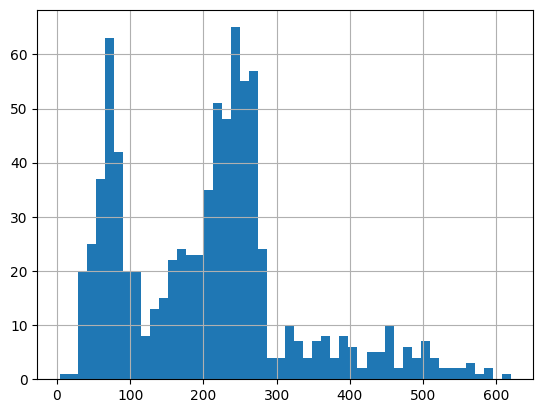

In [13]:
df['text_len'].hist(bins=50)

Распределение бимодальное с модой в 80 и 250.  
Можно сказать, что большая часть текста лежит в диапазоне 280 символов

In [14]:
df.groupby('label')['text_len'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
label,,,,
announcement promise,59,191.898305,164.0,138.749799
development,61,259.557377,255.0,157.355492
"development, specified",276,213.865942,223.5,110.722685
exploit,15,72.333333,70.0,11.962242
interested,1,228.000000,228.0,NaN
"legal, negative",32,136.937500,81.0,103.748125
"legal, positive",21,223.190476,225.0,148.468050
negative,12,86.166667,76.5,31.871427
negative rebuttal,1,160.000000,160.0,NaN


<Axes: >

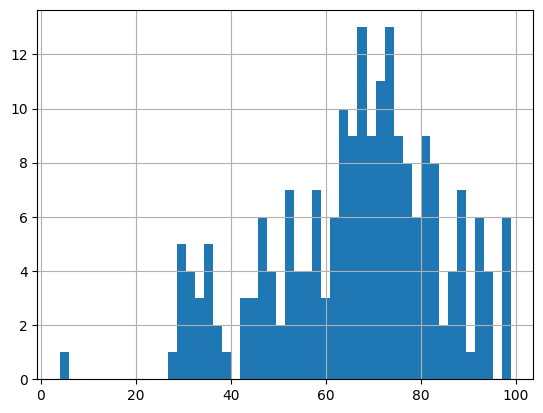

In [15]:
df.query('text_len < 100')['text_len'].hist(bins=50)

In [16]:
df.query('text_len < 100').sort_values('text_len').head()

,text,label,text_len
107,Soon,announcement promise,4
415,Synthetix lists stETH Perps,"development, specified",27
530,Flux partners with Octominer!,"partnership, non-crypto",29
545,"DeFining news: June 9th, 2023",announcement promise,29
19,Open Exchange Adds FTX Claims,positive,29


Коротких бессмысленных текстов не замечено.

#### Уберем классы с кол-вом образцов < 5

In [17]:
df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
positive                     4
sec                          1
negative rebuttal            1
interested                   1
Name: label, dtype: int64

In [18]:
df['label_count'] = df.groupby('label')['label'].transform('count')
df = df.query('label_count > 5')

In [19]:

df['label'].value_counts()

development, specified     276
partnership, non-crypto    260
development                 61
announcement promise        59
start of burn/buyback       32
legal, negative             32
legal, positive             21
raise                       15
exploit                     15
negative                    12
selling                     12
ripple                      10
Name: label, dtype: int64

In [20]:
df = df.reset_index(drop=True)

#### Оценим содержимое наших таргетов

Сами по себе данные представляют собой заколовки новостные на различные таматики.  
  
development, specified - разработка, уточненная
partnership, non-crypto - партнерство, не криптовалютное  
development - разработка  
announcement promise - обещание объявления  
start of burn/buyback - начало сжигания/выкупа  
legal, negative - юридически, негативно  
legal, positive - юридически, позитивно  
raise - привлечение (финансирования)  
exploit - эксплуатировать  
negative - негативный  
selling - продажа  
ripple - криптовалюта Ripple  

Тут сразу видно несколько проблем:  

1. Есть категории как по содержанию заголовка (selling, development, ...), так по эмоциональному содержанию текста (negative).  
При этом одна тема по содержанию разбита на темы по эмоциональности (legal negative, legal positive).
2. Две большие группы development и development specified вообщем относятся к одной группе по содержанию, но различаются глубиной контекста.

Проблемы:
Все это в купе с дисбалансом и маленькой выборкой создаст определенныне сложности при обучении хорошего классификаторв.

Гипотезы:

1. Обучить несколько моделей на определение разных составляющих.
Допустим обучить модель для предсказания любого legit и уже потом делить их на positive и negative.
2. Обучить одну большую сложную модель, которая бы могла разделить классы.
На ум приходит какой-нибудь BERT, его даже не обязательно обучать полностью, можно дообучить только "голову"

In [21]:
for t in df['label'].unique():
    print(f"label: {t}")
    for idx in range(6):
        print(f'''{idx}: {df.query(f'label =="{t}"')['text'].iloc[idx]}''')

    print('____')

label: development, specified
0: The Mines of Dalarnia Update 1.4: Rechained is now LIVE! This new version reintroduces all of the previous blockchain features along with new ones on BSC Mainnet, including: 1⃣ Off-chain and on-chain crafting. 2⃣ New competition mode. 3⃣ Spacehop. 4⃣ New monster, and…
1: Mines of Dalarnia Mainnet—Update 1.4: Rechained
2: Kava in the news [kava 14 accelerates cosmos ecosystem expansion]
3: Build on Base Mainnet with 1RPC
4: No better time than to @buildonbase with Base Mainnet now open to builders - devs, access the network with our dedicated 1RPC endpoint and start building the on-chain future today We can't wait to see what you'll get up to:
5: Dive deep into 14! Introducing the 'internal bridge', a secure module enabling seamless interoperability between Cosmos & Ethereum ecosystems. Effortlessly convert tokens into ERC20 for use in the environment
____
label: partnership, non-crypto
0: SimWin Sports and Immutable: Bringing Digital Ownership to Fantas

Также в тексте очень много симоволов, абривиатур, чисел, ссылок.  
Очевидно, некоторые из таких обозначений могу помогать модели определять класс заголовка, но в тоже время избыточно наращивать размеры словаря и создавать вредный шум.

### Подготовка данных

#### Токенизируем целевую переменную

Отсортируем их по кол-ву (для воспроизводимости) и создадим словарь метки класс : токен

In [22]:
lable2token = {token: idx for idx, token in enumerate(df['label'].value_counts().index)}
print(lable2token)

{'development, specified': 0, 'partnership, non-crypto': 1, 'development': 2, 'announcement promise': 3, 'start of burn/buyback': 4, 'legal, negative': 5, 'legal, positive': 6, 'raise': 7, 'exploit': 8, 'negative': 9, 'selling': 10, 'ripple': 11}


In [23]:
df['labels_token'] = df['label'].replace(lable2token)

<Axes: >

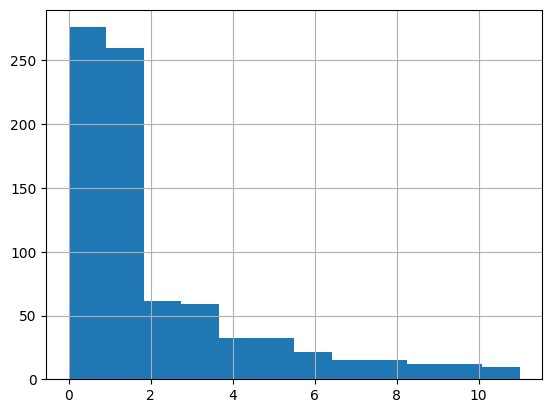

In [24]:

df['labels_token'].hist(bins=12)

#### Отчистим и подготовим данные

Напишем несколько функций для разного типа отчистки данных.  
Сохраним отчищенный текст в новой переменной.

In [25]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_emails(x):
     return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

def remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def remove_special_chars(x):
    x = re.sub(r'[^a-zA-Z0-9@;:\s]', '', x)
    x = ' '.join(x.split())
    return x

def remove_control_characters(x):
    pattern = re.compile(r'[\n\t\r\\\'\"]')
    return re.sub(pattern, '', x)

def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def remove_stopwords(x, stop_words=stop_words):
    return ' '.join([t for t in x.split() if t not in stop_words])

def remove_bch_adress(x):
    return re.sub(r'0x[0-9a-zA-Z]+', '', x).strip()

def remove_words_starting_with_at(x):
    return re.sub(r'@\w+\s*', '', x)

def lemmatize_text(x, lemmatizer=lemmatizer):
    return ' '.join([lemmatizer.lemmatize(w) for w in x.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
col_name = 'text_clean'
df[col_name] = df['text'].apply(lambda x: remove_emails(x)) # убрать адреса email
df[col_name] = df[col_name].apply(lambda x: remove_urls(x)) # убрать urls
df[col_name] = df[col_name].apply(lambda x: remove_bch_adress(x)) # убрать адреса биткойн кошелька
df[col_name] = df[col_name].apply(lambda x: remove_control_characters(x)) # убрать симолы контроля строки
df[col_name] = df[col_name].apply(lambda x: remove_words_starting_with_at(x)) # убрать ссылки на акаунты начинающиеся с @
df[col_name] = df[col_name].apply(lambda x: remove_special_chars(x)) # убрать все специальные символы кроме букв и цифр
df[col_name] = df[col_name].apply(lambda x: remove_stopwords(x)) # убрать все стоп слова
df[col_name] = df[col_name].apply(lambda x: lemmatize_text(x)) # убрать лематезировать текст
df[col_name] = df[col_name].apply(lambda x: x.lower()) # привести к нижнему регистру

In [27]:
df['text_clean'][0]

'the mines dalarnia update 14: rechained live this new version reintroduces previous blockchain feature along new one bsc mainnet including: 1 offchain onchain crafting 2 new competition mode 3 spacehop 4 new monster'

#### Посмотрим самые частые слова после преобразований и до

In [28]:
count_words(df['text_clean']) # отчищенный текст

the            143
tweet          132
new            113
announce       100
we              98
partnership     91
web3            88
mainnet         79
ecosystem       74
launch          74
network         73
were            73
token           67
blockchain      62
news            61
user            60
join            56
thrilled        56
platform        56
first           54
protocol        53
live            53
support         53
this            52
june            50
partner         50
learn           50
exciting        49
coming          49
excited         48
dtype: int64

In [29]:
count_words(df['text']) # исходный текст

the         1167
to           948
and          566
of           481
on           441
with         385
for          367
is           306
in           298
we           295
from         216
our          180
more         147
are          133
this         133
tweet        132
now          131
quoting      131
will         129
that         119
be           119
as           117
you          114
new          114
tier10k      112
re           104
has          103
it           102
announce     100
by            98
dtype: int64

Видно, что в исходном тексте было несколько очень частотных слов таких как the, to,and, ....   
Их удаление не всегда сильно влияет на результат, а для трансформеров лучше вообщем использовать исходные данные.  
Попробуем несколько вариантов в дальнейшем.

### Разделим данные на train, val и test

Разделим данные на 3 группы: обучающая, валидационная и тестовая.  
На обучающей и валидационной выберем модель или модели.  
На тестовой протестируем полученное решение.  

Т.к. данных мало и классы сильно не сбалансированны, то будем использовать стратификацию.

In [30]:
train_val, test, target_train_val, target_test = train_test_split(df['text'],
                                                                  df['labels_token'].values,
                                                                  test_size=0.15,
                                                                  stratify=df['labels_token'],
                                                                  random_state=42)

In [31]:
train, val, target_train, target_val = train_test_split(train_val,
                                                        target_train_val,
                                                        test_size=0.2,
                                                        stratify=target_train_val,
                                                        random_state=42)

Также разобъем очищенную выборку

In [32]:
train_val_clean, test_clean, target_train_val_clean, target_test_clean = train_test_split(df['text_clean'],
                                                                                          df['labels_token'].values,
                                                                                          test_size=0.15,
                                                                                          stratify=df['labels_token'],
                                                                                          random_state=42)

In [33]:
train_clean, val_clean, target_train_clean, target_val_clean = train_test_split(train_val_clean,
                                                                                target_train_val_clean,
                                                                                test_size=0.2,
                                                                                stratify=target_train_val_clean,
                                                                                random_state=42)

In [34]:
print(f'train: {train.shape}')
print(f'val: {val.shape}')
print(f'test: {test.shape}')

train: (547,)
val: (137,)
test: (121,)


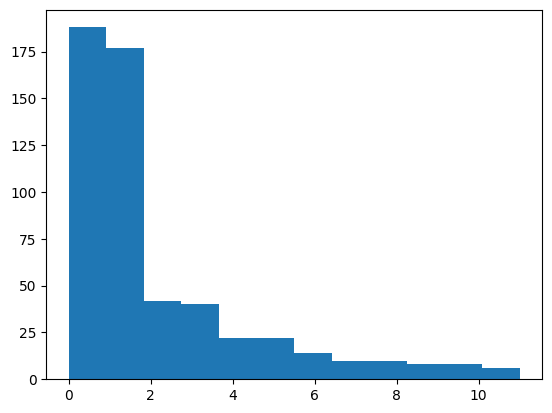

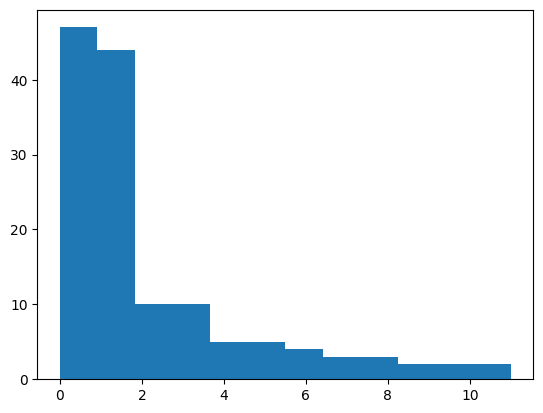

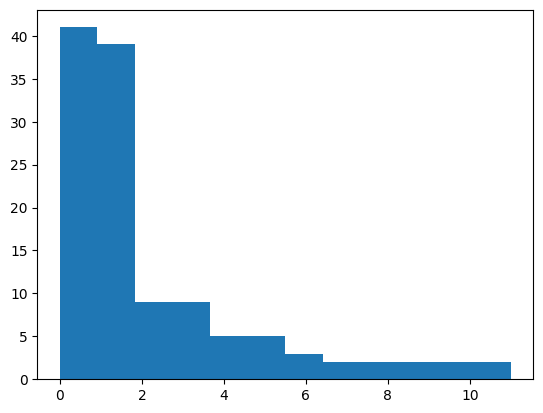

In [35]:
plt.hist(target_train, bins=12)
plt.show()
plt.hist(target_val, bins=12)
plt.show()
plt.hist(target_test, bins=12)
plt.show()

данные разделены пропорционально по каждому классу, распределение классов не изменилось.

### Выбор модели

При дальнейшем выборе моделей будем следовать такому плану.  
Извлечем признаки из текста двумя способами.  
1. Применим TFIDF
2. Применим предобученный BERT и возьмем эмебединг предложения на последнем слое
3. Конкатенируем результаты
3. Сожмем в PCA
4. Передадим в LogReg или Catboost

Оценивать качество моделей будем используя f1-macro.  
Эта метрика равноценно учитывает классы, поэтому ошибки в минорных классах будут "стоить дорого".

In [36]:
if torch.cuda.is_available() == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

В качестве модели для токенизации возьмем ProsusAI/finbert, обученную на определение тональности экономических новостей.  
https://huggingface.co/ProsusAI/finbert  

Идея в том, что TFIDF должен дать нам понимание о составе текста, а BERT добавит информацию о тональности.

In [37]:
HF = 'ProsusAI/finbert'

tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

model = AutoModel.from_pretrained(HF)
model.to(device)

pca_model = PCA(random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=38000, ngram_range=(1, 4))

scores = []

cv_stratified = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

logit = LogisticRegression(class_weight='balanced',
                           max_iter=150,
                           C=1,
                           solver='lbfgs',
                           multi_class='multinomial',
                           random_state=42,
                           n_jobs=4)

Т.к. данные имеют сильный дисбаланс и при этом выборка небольшая, то возьмем 7 сплитов данных, чтобы лучше оценить качество.  
Идея в том, что "большое" кол-во фолдов используется для такого типа выборок.

### На исходных (неочищенных) данных

Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **без BERT**.

In [38]:
model_wo_bert = []
scores_wo_bert = []
pca_wo_bert = []
tfidf_wo_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val.values,
                                                                  target_train_val,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_wo_bert.append(logit)
    scores_wo_bert.append(score)
    pca_wo_bert.append(pca)
    tfidf_wo_bert.append(tfidf)

print(f'mean_score: {np.mean(scores_wo_bert)}')
print(f'mean_score: {np.std(scores_wo_bert)}')


mean_score: 0.5401048260937618
mean_score: 0.08221644758170096


Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [39]:
model_w_bert = []
scores_w_bert = []
pca_w_bert = []
tfidf_w_bert = []

for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val.values,
                                                                  target_train_val,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  bert=True,
                                                                  device=device)

    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_w_bert.append(logit)
    scores_w_bert.append(score)
    pca_w_bert.append(pca)
    tfidf_w_bert.append(tfidf)

print(f'mean_score: {np.mean(scores_w_bert)}')
print(f'std_score: {np.std(scores_w_bert)}')



mean_score: 0.47072828036799735
std_score: 0.08781478791291004


### На очищенных данных

Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и без **BERT**.

In [40]:
model_wo_bert_clean = []
scores_wo_bert_clean = []
pca_wo_bert_clean = []
tfidf_wo_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):
    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val_clean.values,
                                                                  target_train_val_clean,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_wo_bert_clean.append(logit)
    scores_wo_bert_clean.append(score)
    pca_wo_bert_clean.append(pca)
    tfidf_wo_bert_clean.append(tfidf)

print(f'mean_score: {np.mean(scores_wo_bert_clean)}')
print(f'mean_score: {np.std(scores_wo_bert_clean)}')


mean_score: 0.4579885729291037
mean_score: 0.08862538109978872


Оценим качество модели логистической регрессии на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [41]:
model_w_bert_clean = []
scores_w_bert_clean = []
pca_w_bert_clean = []
tfidf_w_bert_clean = []

for index_train, index_val in cv_stratified.split(train_val_clean, target_train_val_clean):

    X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline(train_val_clean.values,
                                                                  target_train_val_clean,
                                                                  tokenizer_bert=tokenizer,
                                                                  model_bert=model,
                                                                  pca=pca_model,
                                                                  tfidf=vectorizer,
                                                                  index_train=index_train,
                                                                  index_val=index_val,
                                                                  bert=True,
                                                                  device=device)


    logit.fit(X_train, y_train)
    y_pred = logit.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')

    model_w_bert_clean.append(logit)
    scores_w_bert_clean.append(score)
    pca_w_bert_clean.append(pca)
    tfidf_w_bert_clean.append(tfidf)

print(f'mean_score: {np.mean(scores_w_bert_clean)}')
print(f'mean_score: {np.std(scores_w_bert_clean)}')

mean_score: 0.424441661060646
mean_score: 0.08449825488305704


**Вывод**


Как видим, модели обученные на очищенных данных показывают хуже результаты, чем "сырые".

В дальнейшем будем использовать модели обученные на сырых данных.


Оценим качество модели логистической регрессии на **обучающей и валидационной** выборке **с TF-IDF** и **без BERT**.

mean_score: 0.43966262747863877
              precision    recall  f1-score   support

           0       0.64      0.57      0.61        47
           1       0.75      0.89      0.81        44
           2       0.36      0.40      0.38        10
           3       0.29      0.40      0.33        10
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.50      0.33      0.40         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.64       137
   macro avg       0.42      0.47      0.44       137
weighted avg       0.59      0.64      0.61       137



<Axes: >

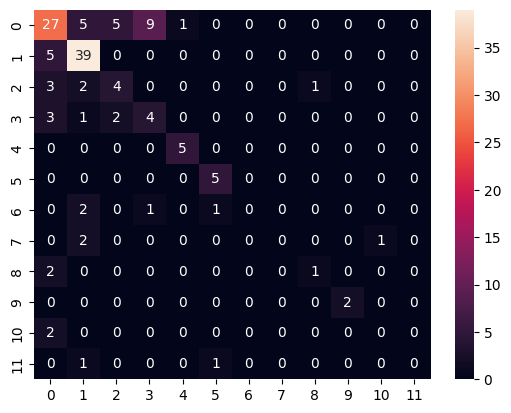

In [42]:
scores_full = []
pred_prob_full = []

X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline((train, val),
                                                              (target_train, target_val),
                                                              tokenizer_bert=tokenizer,
                                                              model_bert=model,
                                                              pca=pca_model,
                                                              tfidf=vectorizer,
                                                              index_train=None,
                                                              index_val=None,
                                                              bert=False,
                                                              cv=False)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full.append(score)
pred_prob_full.append(y_pred_prob)
model_full = deepcopy(logit)
pca_full = deepcopy(pca)
tfidf_full = deepcopy(tfidf)

print(f'mean_score: {np.mean(scores_full)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


Оценим качество модели логистической регрессии на **обучающей и валидационной** выборки **с TF-IDF** и **с BERT**.

mean_score: 0.36139699367253547
              precision    recall  f1-score   support

           0       0.48      0.26      0.33        47
           1       0.59      0.59      0.59        44
           2       0.33      0.30      0.32        10
           3       0.17      0.70      0.27        10
           4       1.00      0.80      0.89         5
           5       0.40      0.80      0.53         5
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.43       137
   macro avg       0.41      0.39      0.36       137
weighted avg       0.49      0.43      0.43       137



<Axes: >

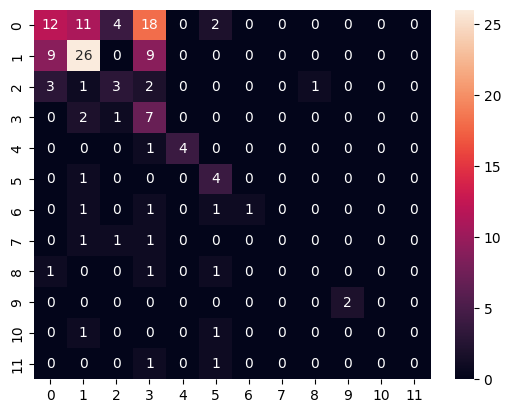

In [43]:
scores_full_w_bert = []
pred_prob_full_w_bert = []

X_train, X_val, y_train, y_val, pca, tfidf = dataset_pipeline((train, val),
                                                              (target_train, target_val),
                                                              tokenizer_bert = tokenizer,
                                                              model_bert = model,
                                                              pca = pca_model,
                                                              tfidf = vectorizer,
                                                              index_train = index_train,
                                                              index_val = index_val,
                                                              bert=True,
                                                              cv=False,
                                                              device=device)

logit.fit(X_train, y_train)
y_pred = logit.predict(X_val)
y_pred_prob = logit.predict_proba(X_val)
score = f1_score(y_val, y_pred, average='macro')

scores_full_w_bert.append(score)
pred_prob_full_w_bert.append(y_pred_prob)
model_full_w_bert = deepcopy(logit)
pca_full_w_bert = deepcopy(pca)
tfidf_full_w_bert = deepcopy(tfidf)

print(f'mean_score: {np.mean(scores_full_w_bert)}')
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)


### Выводы

На сырых данных модель показала лучше результат, чем на обработанных.   


Судя по матрице ошибок, линейная модель хорошо определяет классы с большими числом объектов, хуже классы с маленьким числом объектов.

При этом из-за использования **f1-macro** в качестве целевой метрики получаем сильный штраф за ошибки в минорных классах, в то время как ошибки в мажорных классах менее критичны.


Кросс-валидация показывает, что модель у которой датасет включается в себя TF-IDF имет средний скор выше модели обученой на TFIDF и BERT.


### CatBoost

LogReg показала хороший результат на TF-IDF.  

Гипотеза:
- Бустингом можно выжать больше пользы из данных, найти новые зависимости.  

Проблемы:
- Бустинги не всегда хорошо работают, если есть сильная линейная связь
- В бустинги надо аккуратно настраивать гиперпараметры

Решение:
- Возьмем CatBoost, он "из коробки" показывает хорошие результаты, если будет похоже на лучший результат, чем LogReg, то можно подобрать гиперпараметры, если нет, то нет.

In [44]:
cb = CatBoostClassifier(task_type="GPU",
                        auto_class_weights='Balanced',
                        loss_function='MultiClass',
                        verbose=True)

Оценим качество модели Catboost на **кросс-валидации** обучающей+валидационной выборке **с TF-IDF** и **с BERT**.

In [45]:
cb_model_w_bert = []
cb_scores_w_bert = []
for index_train, index_val in cv_stratified.split(train_val, target_train_val):
    X_train, X_val, y_train, y_val, _, _ = dataset_pipeline(train_val.values,
                                                      target_train_val,
                                                      tokenizer_bert=tokenizer,
                                                      model_bert=model,
                                                      pca=pca_model,
                                                      tfidf=vectorizer,
                                                      index_train=index_train,
                                                      index_val=index_val,
                                                      bert=True,
                                                      cv=True,
                                                      device=device)

    text_pool = Pool(data=X_train, label=y_train)
    eval_pool = Pool(data=X_val, label=y_val)

    cb.fit(text_pool, eval_set=eval_pool, verbose=False)
    y_pred = cb.predict(eval_pool)
    score = f1_score(y_val, y_pred, average='macro')

    cb_scores_w_bert.append(score)
    cb_model_w_bert.append(cb)

print(np.mean(cb_scores_w_bert))
print(np.std(cb_scores_w_bert))


0.40763424436528484
0.08224868928364143


In [46]:
cb_scores_w_bert

[0.4297771672771673,
 0.2708763918929744,
 0.40074131658638706,
 0.5050856550856552,
 0.38475724991854027,
 0.5232744107744108,
 0.33892751902185864]

Оценим качество модели Catboost на **обучающей и валидационной** выборки **с TF-IDF** и **с BERT**.

0.3223864226069727
              precision    recall  f1-score   support

           0       0.54      0.40      0.46        47
           1       0.68      0.77      0.72        44
           2       0.14      0.20      0.17        10
           3       0.17      0.20      0.18        10
           4       0.80      0.80      0.80         5
           5       0.40      0.80      0.53         5
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.49       137
   macro avg       0.31      0.35      0.32       137
weighted avg       0.49      0.49      0.48       137



<Axes: >

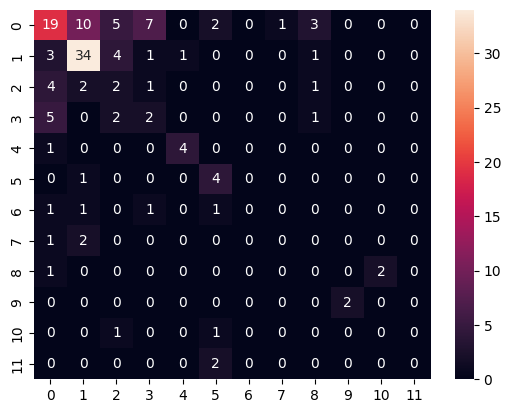

In [47]:
cb_scores_full = []
cb_model_full = []

X_train, X_val, y_train, y_val, _, _ = dataset_pipeline((train, val),
                                                        (target_train, target_val),
                                                        tokenizer_bert=tokenizer,
                                                        model_bert=model,
                                                        pca=pca_model,
                                                        tfidf=vectorizer,
                                                        index_train=index_train,
                                                        index_val=index_val,
                                                        bert=True,
                                                        cv=False,
                                                        device=device)

text_pool = Pool(data=X_train, label=y_train)
eval_pool = Pool(data=X_val, label=y_val)

cb.fit(text_pool, eval_set=eval_pool, verbose=False)
y_pred = cb.predict(eval_pool)
score = f1_score(y_val, y_pred, average='macro')

cb_scores_full.append(score)
cb_model_full.append(cb)

print(np.mean(cb_scores_full))
print(classification_report(y_val, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True)

In [48]:
cb_scores_full

[0.3223864226069727]

Catboost с использованием TFIDF и CV показал лучше результат, чем c TFIDF и BERT.  
Но лучшая метрика CatBoost хуже LogReg  

Остановим свой выбора на LogReg на сырых данных

**Вывод**  
Комбинирование TFIDF с BERT эмбедингами не дает прироста качества.  
Использование очищенных данных дает худший результат, чем на сырых. (TFIDF сам убирает стоп слова и приводит к нижнему регистру)  

### BERT

Т.к. датасет маленький, классов много, дисбаланс большой, то можно предположить следующие гипотезы, в которых BERT может быть полезен:  
1. В качестве признаков для модели (реализовано ранее с линейной регрессией, показало эффективность)
2. Самостоятельная модель, которую можно дообучить на данных и получить одну модель способную эффективно определять классы.  
Тут проблем несколько:
- Модель требует все-таки большую выборку для дообучения, чтобы показать значитенльный результат. На мальенком кол-ве данных сложные зависимости она просто не сможет достать.
- Модель скорее настроена на определения "смысла" текста, нежели на схожесть по словам. А судя по датасету и результатам TF-IDF, да и в целом задачи классификации текстов, частотность слов является хорошим предиктором для большинства задачи.  
3. Что успел попробовать?  
- Попытки обучить самостоятельную модель не показали результатов превышающих LogReg.  Пробовал разные предобученные модели, надстраивал "головы", дообучал блоки внимания, потратил много часов GPU в Colab, но лучше LogReg не получилось сделать.  

**Решение**  
Попробовать объединить результаты LogReg обученной на TFIDF и BERT, используя взвешенную сумму уверенносте (вероятностей) моделей.  
Смысл в том, что TF-IDF ориентируется на конструкцию текста, а BERT на "смысла" текста. (очень упрощённо)

**Предобученная модель BERT**  
Возьмем предобученную модель, в которой обучим только верхние слои (последний болк внимания, pooler и классификатор)

In [49]:
HF = 'ProsusAI/finbert'

**Подготовим данные**   

Т.к. CV на таких моделях проводить слишком трудозатратно и не особо эффективно, то дообучим модель на train и val.

In [50]:
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)
train_dataloader, val_dataloader, test_dataloader = dataset(train, val, test, tokenizer, target_train, target_val, target_test, batch_size=50)

**Обучение моделей**  
Обучим модели и сохраним модель с минимальной ошибкой на валидационном датасете


In [51]:
# сбор и отчистка мусора перед обучением
import gc
gc.collect()
torch.cuda.empty_cache()

Чтобы обучить модель заново раскоментируйте код (Ctrl + /)




Training loss: 1.531
Validation loss: 1.938
0.21523051412256064


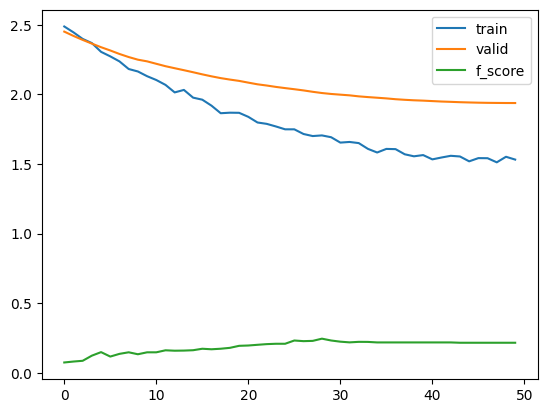

In [52]:
# PATH_MODEL='./models/bert_multiclass1.pt'
# epochs = 50

# model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)
# model.to(device)

# optimizer = AdamW(model.parameters(), lr=1e-5)

# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target_train), y=target_train)
# class_weights = (class_weights / class_weights.sum())
# class_weights = torch.tensor(class_weights).float().to(device)

# criterion = nn.CrossEntropyLoss(weight=class_weights)

# _, _, _ = trainer_pipeline(epochs=epochs,
#                 PATH_MODEL=PATH_MODEL,
#                 model = model,
#                 HF = HF,
#                 optimizer = optimizer,
#                 scheduler = scheduler,
#                 criterion = criterion,
#                 train_dataloader = train_dataloader,
#                 val_dataloader = val_dataloader,
#                 device=device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.20      0.02      0.04        47
           1       0.58      0.75      0.65        44
           2       0.22      0.20      0.21        10
           3       0.18      0.60      0.28        10
           4       0.50      0.80      0.62         5
           5       0.25      0.20      0.22         5
           6       0.17      0.25      0.20         4
           7       0.00      0.00      0.00         3
           8       0.25      0.67      0.36         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2

    accuracy                           0.36       137
   macro avg       0.20      0.29      0.22       137
weighted avg       0.32      0.36      0.30       137



<Axes: >

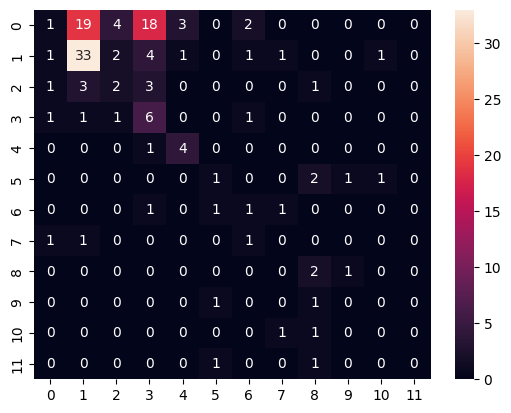

In [53]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(target_train), y=target_train)
class_weights = (class_weights / class_weights.sum())
class_weights = torch.tensor(class_weights).float().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

PATH_MODEL='./models/bert_multiclass1.pt'
model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL, map_location=device))
model.to(device)

valid_loss, valid_pred, valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(valid_labels, np.argmax(valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(valid_labels, np.argmax(valid_pred, axis=1).flatten()), annot=True)


Эта модель показывает лучший скор на меньшем размере батча, причем различие значительное.  

### BERT + AUGMENTATION

Посмотрим на результаты модели при сбалансированной выборке при помощи аугументации.   
Будет заменять слова на синонимы.  
Используем библиотека (nlpaug)

In [54]:
aug = naw.SynonymAug(aug_src='wordnet')
unique, counts = np.unique(target_train, return_counts=True)

add_train = train.to_list()
add_target_train = list(target_train)

max_count = max(counts)

for idx, n in enumerate(unique):
    features_num = max_count - counts[idx]
    examples = np.random.choice(np.array(train.to_list())[target_train == n], features_num, replace=True)

    for sentance in examples:
        add_train.extend(aug.augment(sentance))
    add_target_train.extend([n]*features_num)

In [55]:
len(add_train)

2256

In [56]:
len(add_target_train)

2256

In [57]:
train_dataloader, val_dataloader, test_dataloader = dataset(add_train, val, test, tokenizer, add_target_train, target_val, target_test, batch_size=150)


Training loss: 0.364
Validation loss: 0.965
0.482646698197744


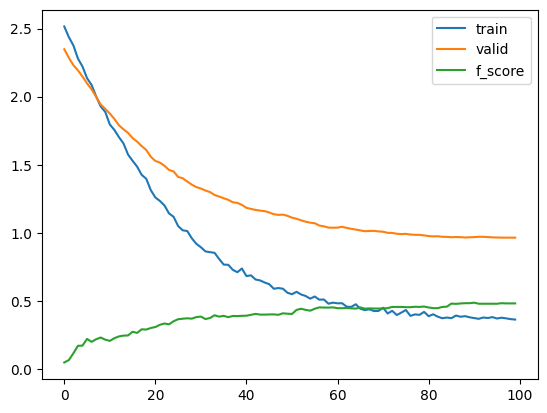

In [58]:
# PATH_MODEL_BALANCED = './models/bert_multiclass_balanced11.pt'
# epochs = 100

# model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)

# optimizer = AdamW(model.parameters(), lr=1e-5)

# total_steps = len(train_dataloader) * epochs
# optimizer = AdamW(model.parameters(), lr=1e-5)

# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=3, num_training_steps=total_steps)

# criterion = nn.CrossEntropyLoss()

# _, _, _ = trainer_pipeline(epochs=epochs,
#                           PATH_MODEL=PATH_MODEL_BALANCED,
#                           model = model,
#                           HF = HF,
#                           optimizer = optimizer,
#                           scheduler = scheduler,
#                           criterion = criterion,
#                           train_dataloader = train_dataloader,
#                           val_dataloader = val_dataloader,
#                           device=device)

Применим обученную и сохраненную модель.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.55      0.66        47
           1       0.77      0.84      0.80        44
           2       0.60      0.60      0.60        10
           3       0.50      0.60      0.55        10
           4       0.56      1.00      0.71         5
           5       0.45      1.00      0.62         5
           6       0.50      0.50      0.50         4
           7       0.33      0.67      0.44         3
           8       0.50      0.33      0.40         3
           9       0.00      0.00      0.00         2
          10       0.50      0.50      0.50         2
          11       0.00      0.00      0.00         2

    accuracy                           0.66       137
   macro avg       0.46      0.55      0.48       137
weighted avg       0.68      0.66      0.66       137



<Axes: >

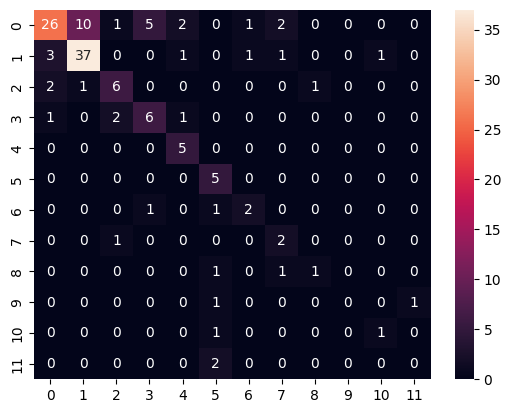

In [61]:
criterion = nn.CrossEntropyLoss()
PATH_MODEL_BALANCED = './models/bert_multiclass_balanced11.pt'

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL_BALANCED, map_location=device))
model.to(device)
add_valid_loss, add_valid_pred, add_valid_labels = evaluate(model, criterion, val_dataloader, device=device)

print(classification_report(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten(), zero_division=0))
sns.heatmap(confusion_matrix(add_valid_labels, np.argmax(add_valid_pred, axis=1).flatten()), annot=True)

**Вывод**  
Как видим модель BERT обученная на аугументированных данных показывает лучший результат по сравнению с моделью использующей балансировку функции потерь.

### Blending

**Подберем коэффициент для смешивания предсказания моделей.**  
Для этого возьмем предсказания LogReg модели обученной только на TDIDF и BERT и подберем коэф, при котором метрика максимальная.  
argmax(pred_bert_proba * (1- k) + pred_lr_proba * k)  
( скорее всего это не самый объектиыный способ подбора, можно попробовать кросс-валидации и тп.)

In [62]:
bert_pred = F.softmax(torch.tensor(add_valid_pred)).detach().cpu().numpy()

<ipython-input-62-78678ce0047d>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  bert_pred = F.softmax(torch.tensor(add_valid_pred)).detach().cpu().numpy()


In [63]:
lr_pred = pred_prob_full[0]

**Найдем оптимальный порог "trsh".**  
Для этого выберем такой порог, при котором среднее взвешенное вероятностей дает максимальную метрику f1-macro.

In [64]:
res_score = {}

for i in range(0, 100, 1):
    i = i / 100
    y_pred_blend = np.argmax(bert_pred * (1 - i) + lr_pred * i, axis=1)
    score = f1_score(target_val, y_pred_blend, average='macro')
    res_score[i] = score

for key, value in res_score.items():
    if value == max(res_score.values()):
        trsh = key
print(f'trsh: {trsh}')

trsh: 0.89


Смешаем и предскажем

In [65]:
y_pred_blend = np.argmax(bert_pred*(1 - trsh) + lr_pred*trsh, axis=1)

              precision    recall  f1-score   support

           0       0.78      0.68      0.73        47
           1       0.83      0.91      0.87        44
           2       0.71      0.50      0.59        10
           3       0.53      0.80      0.64        10
           4       0.83      1.00      0.91         5
           5       0.50      1.00      0.67         5
           6       1.00      0.25      0.40         4
           7       0.67      0.67      0.67         3
           8       0.50      0.33      0.40         3
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.00      0.00      0.00         2

    accuracy                           0.74       137
   macro avg       0.66      0.64      0.61       137
weighted avg       0.75      0.74      0.73       137



<Axes: >

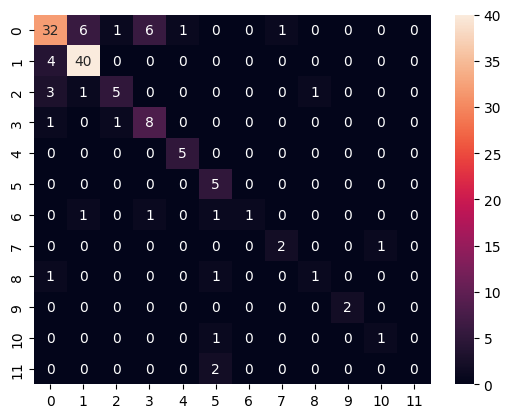

In [66]:
print(classification_report(target_val, y_pred_blend, zero_division=0))
sns.heatmap(confusion_matrix(target_val, y_pred_blend), annot=True)

**Вывод**  
Как видим смешивание результатов работы логистической регрессии и BERT показывает превосходящий все предыдущие варианты.  
Протестируем данную комбинацию.

### Test

Выше мы сделали два основных вывода:  
1. LogReg с TFIDF показала лучшее качество.  
2. Смешивание результатов прогноза LogReg на TFIDF и BERT дообученного на train дает маленький, но прирост в метрике.  

Проверим модель на отложенной выборке test

Получим предсказание от LogReg

score: 0.6656178001807513
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        41
           1       0.72      0.87      0.79        39
           2       0.67      0.22      0.33         9
           3       0.64      0.78      0.70         9
           4       1.00      0.40      0.57         5
           5       1.00      1.00      1.00         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2

    accuracy                           0.74       121
   macro avg       0.81      0.62      0.67       121
weighted avg       0.75      0.74      0.72       121



<Axes: >

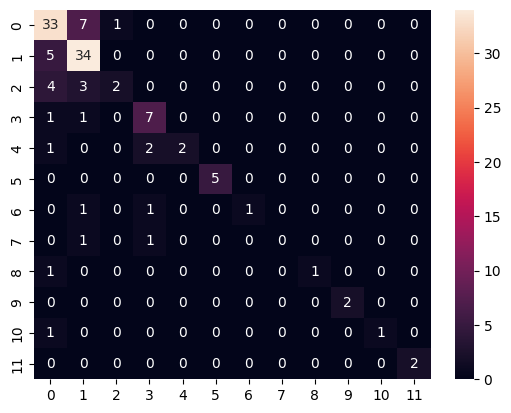

In [67]:
X_train, X_val, y_train, y_val, _, _ = dataset_pipeline(test,
                                                        target_test,
                                                        tokenizer_bert = AutoTokenizer.from_pretrained(HF, do_lower_case=True),
                                                        model_bert = AutoModel.from_pretrained(HF),
                                                        pca = pca_full,
                                                        tfidf = tfidf_full,
                                                        index_train = index_train,
                                                        index_val = index_val,
                                                        bert=False,
                                                        cv=False,
                                                        is_test=True,
                                                        device=device)

logit = model_full
y_pred = logit.predict(X_val)
y_pred_proba = logit.predict_proba(X_val)
score = f1_score(target_test, y_pred, average='macro')

print(f'score: {score}')
print(classification_report(target_test, y_pred, zero_division=0))
sns.heatmap(confusion_matrix(target_test, y_pred), annot=True)


Получим предсказание от Bert

In [68]:
PATH_MODEL_BALANCED = './models/bert_multiclass_balanced11.pt'

model = AutoModelForSequenceClassification.from_pretrained(HF, num_labels=len(set(target_train_val)), ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(PATH_MODEL_BALANCED, map_location=device))
model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss()

test_loss, test_pred, test_labels = evaluate(model, criterion, test_dataloader, device=device)
logist_softmax = F.softmax(torch.tensor(test_pred)).detach().cpu().numpy()

# итоговое предсказание
test_pred_concat = np.argmax(logist_softmax*(1 - trsh) + y_pred_proba*trsh, axis=1) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-68-787f1162d9d0>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logist_softmax = F.softmax(torch.tensor(test_pred)).detach().cpu().numpy()


              precision    recall  f1-score   support

           0       0.74      0.78      0.76        41
           1       0.77      0.87      0.82        39
           2       0.50      0.22      0.31         9
           3       0.75      1.00      0.86         9
           4       0.75      0.60      0.67         5
           5       1.00      1.00      1.00         5
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         2

    accuracy                           0.77       121
   macro avg       0.79      0.69      0.71       121
weighted avg       0.76      0.77      0.75       121



<Axes: >

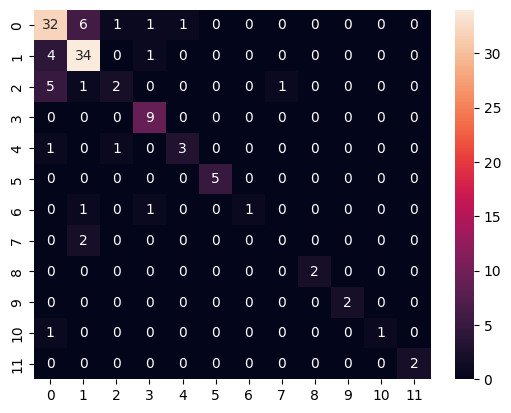

In [69]:
print(classification_report(test_labels, test_pred_concat, zero_division=0))
sns.heatmap(confusion_matrix(test_labels, test_pred_concat), annot=True)

**Вывод**  
По результатам работы модели учета оценки как LR, так и BERT видим, что совместная оценка превосходит одинучную LR.  

### Inference

In [70]:
lable2token

{'development, specified': 0,
 'partnership, non-crypto': 1,
 'development': 2,
 'announcement promise': 3,
 'start of burn/buyback': 4,
 'legal, negative': 5,
 'legal, positive': 6,
 'raise': 7,
 'exploit': 8,
 'negative': 9,
 'selling': 10,
 'ripple': 11}

In [71]:
text_to_classify = ["This is an example sentence for classification."]

PATH_MODEL_BALANCED = './models/bert_multiclass_balanced11.pt'
tokenizer = AutoTokenizer.from_pretrained(HF, do_lower_case=True)

lable, name = inference(text=pd.Series(text_to_classify),
                        PATH_MODEL=PATH_MODEL,
                        pca=pca_full,
                        tfidf=tfidf_full,
                        model_lr=model_full,
                        HF=HF,
                        tokenizer=tokenizer,
                        trsh=trsh,
                        lable2token=lable2token)
print(f"_____lable: {lable}, name: {name}_____")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_____lable: [6], name: ['legal, positive']_____


/content/src/functions_bert.py:328: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logist_softmax = F.softmax(torch.tensor(logits)).detach().cpu().numpy()
/content/src/functions_bert.py:328: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logist_softmax = F.softmax(torch.tensor(logits)).detach().cpu().numpy()


## Итого

Изучили данные, отчистили от малых классов и дубликатов.  
Проверили ряд гипотез таких как:  

Объединение признаков TFIDF и эмбедингов BERT может дать прирост в качестве.  
Гипотеза не оправдалась.  
2. CatBoost может дать лучшее качество на данных TFIDF.  
Гипотеза не опрадвалась  
3. Можно обучить один большой BERT и она даст лучшее качетво.  
Гипотеза не оправдалась.  
4. Можно взять лучшую линейную модель и BERT дообученный на наших данных, взять среднее взвешенное предсказаний и это считать вероятностью класса.  
Гипотеза в целом оправдалась, получилось добиться более высокого качества на валидационной выборке и соизмеримые результаты на тестовой.  

При этом можно заметить, что модель несмотря на все ухищрения все равно плохо предсказывает некоторые классы.  

При этом аугументация текста используя замену слов на синонимы дала значительный прирост качества BERT по сравнению с моделью, где дисбаланс решался весами.  

TO DO  
Можно пытаться обучать BERT на комбинации аугументаций  
Можно настроить гиперпараметры градинтного бустинга и попробовать получить качество выше чем LogReg  
Можно попытаться обучить ряд моделей OnevsAll, чтобы определять таким образом проблемыные классы.   Мои попытки так сделать эффекта не принесли.  
Можно подумать над извлечением дополнительных фичей из текста и добавления их в модели.  